MVTamperBench Video Tampering Script
====================================

This script is designed to tamper with videos from the MVBench dataset to create a custom benchmark dataset, named MVTamperBench,
for evaluating the robustness of Video Language Models (VLMs) against tampering effects.

Key Features:
-------------
1. **Tampering Effects**:
   - Substitution: Replaces a segment of a video with a segment from another video.
   - Masking: Applies a black mask to a segment of the video.
   - Repetition: Repeats a segment of the video to increase its length.
   - Drop: Removes a segment from the video to shorten its length.
   - Rotation: Rotates a segment of the video by 90 degrees.

2. **Customization**:
   - Specify the tampering location: start, middle, or end of the video.
   - Define the duration of the tampering effect.

3. **Metadata Generation**:
   - Automatically generates detailed metadata (in both JSON and CSV formats) for each tampered video,
     including information about the tampering effect, location, duration, and video properties (e.g., FPS, resolution).

4. **Output Management**:
   - Saves the tampered videos and their metadata in organized directories corresponding to tampering locations.

5. **Integration Ready**:
   - Output is designed for seamless integration with VLMEvalKit for benchmarking and analysis.

Usage Instructions:
-------------------
1. Place your MVBench dataset videos in the input directory specified in the code.
2. Configure the parameters (e.g., tampering location and duration) as needed.
3. Run the script to generate tampered videos and the corresponding metadata.

Output:
-------
The script creates a new benchmark dataset, MVTamperBench, with the tampered videos and comprehensive metadata.

Note:
-----
- The FPS is set to 24 frames per second by default.
- Ensure sufficient storage space for saving tampered videos and metadata.
- For questions or issues, refer to the comments in the code for clarification.

# Importing the necessary packages

In [ ]:
import cv2  # OpenCV for video processing
import numpy as np  # NumPy for numerical operations
import os  # For file and directory operations
import json  # To save metadata as JSON
import csv  # To save metadata as CSV
# from google.colab import drive  # For Google Drive integration
import random  # To select random frames from other videos
from datetime import datetime  # For adding processing date
import pandas as pd  # For CSV file operations

# Mount Google Drive to access files
# drive.mount('/content/drive')


# Code for introducing Tampering Effects

In [ ]:
# Base class for tampering effects with memory management
class TamperingEffect:
    def __init__(self, video_path, output_path, all_videos, tampering_location, tampering_duration):
        self.video_path = video_path  # Path to the input video
        self.output_path = output_path  # Directory to save the tampered video
        self.frame_count = 0  # Total number of frames in the video
        self.frame_size = None  # Size of the frames in the video
        self.cap = None  # Video capture object
        self.all_videos = all_videos  # List of all video paths for substitution
        self.tampering_duration = tampering_duration
        self.frames_per_second = 0
        self.frames_to_tamper = 0 # Convert tampering duration (secs) to number of frames (24 FPS)
        self.tampering_location = tampering_location  # Start, middle, or end tampering
        self.tampering_start_idx = 0  # To store tampering start frame index

    # Load video properties without holding frames in memory
    def initialize_video(self):
        self.cap = cv2.VideoCapture(self.video_path)
        self.frame_count = int(self.cap.get(cv2.CAP_PROP_FRAME_COUNT))
        self.frame_size = (int(self.cap.get(cv2.CAP_PROP_FRAME_WIDTH)),
                           int(self.cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
        self.frames_per_second = int(self.cap.get(cv2.CAP_PROP_FPS))
        self.frames_to_tamper = self.frames_per_second * self.tampering_duration

        # Determine the starting point for tampering based on location
        if self.tampering_location == 'start':
            self.start_point = 0
        elif self.tampering_location == 'end':
            self.start_point = self.frame_count - self.frames_to_tamper
        else:  # Default to 'middle'
            self.start_point = (self.frame_count // 2) - (self.frames_to_tamper // 2)

    # Save the tampered video using a provided frame processing function
    def save_video(self, process_frame_func, output_file):
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Define codec for the output video
        out = cv2.VideoWriter(output_file, fourcc, self.frames_per_second, self.frame_size)  # Frame rate set to 24 FPS

        self.cap.set(cv2.CAP_PROP_POS_FRAMES, 0)  # Rewind the video to the start
        for i in range(self.frame_count):
            ret, frame = self.cap.read()  # Read the current frame
            if not ret:
                break
            tampered_frame = process_frame_func(frame, i)  # Process the frame
            if tampered_frame is not None:
                out.write(tampered_frame)  # Write the frame

        out.release()  # Release VideoWriter
        self.cap.release()  # Release the video capture object

    def process_frame(self, frame, idx):
        raise NotImplementedError("Subclasses should implement this method.")

# Subclass for substituting frames
class SubstituteFrame(TamperingEffect):
    def __init__(self, video_path, output_path, all_videos, tampering_location='middle', tamper_duration=2):
        super().__init__(video_path, output_path, all_videos, tampering_location, tamper_duration)
        self.substitute_frames = []

    def get_random_video(self):
        other_videos = [v for v in self.all_videos if v != self.video_path]
        random_video = random.choice(other_videos)
        return random_video

    def extract_random_frames_from_other_video(self):
        random_video_path = self.get_random_video()
        cap_other = cv2.VideoCapture(random_video_path)
        frame_count_other = int(cap_other.get(cv2.CAP_PROP_FRAME_COUNT))

        start_frame = random.randint(0, frame_count_other - self.frames_to_tamper)
        cap_other.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
        for _ in range(self.frames_to_tamper):
            ret, frame = cap_other.read()
            if ret:
                self.substitute_frames.append(frame)
            else:
                break
        cap_other.release()

    def process_frame(self, frame, idx):
        if idx == 0 and not self.substitute_frames:
            self.extract_random_frames_from_other_video()

        if self.start_point <= idx < self.start_point + self.frames_to_tamper:
            return self.substitute_frames[idx - self.start_point]
        else:
            return frame

# Subclass for masking frames
class MaskFrame(TamperingEffect):
    def process_frame(self, frame, idx):
        if self.start_point <= idx < self.start_point + self.frames_to_tamper:
            return np.zeros_like(frame)
        return frame

# Subclass for repeating frames with corrected logic
class RepeatFrame(TamperingEffect):
    def save_video(self, process_frame_func, output_file):
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Define codec for the output video
        out = cv2.VideoWriter(output_file, fourcc, self.frames_per_second, self.frame_size)  # Frame rate set to 24 FPS

        repeated_frames = []
        self.cap.set(cv2.CAP_PROP_POS_FRAMES, 0)  # Rewind the video to the start

        for i in range(self.frame_count):
            ret, frame = self.cap.read()  # Read the current frame
            if not ret:
                break
            tampered_frame = process_frame_func(frame, i)  # Process the frame

            # Collect frames that fall within the tampering duration to repeat later
            if self.start_point <= i < self.start_point + self.frames_to_tamper:
                repeated_frames.append(tampered_frame)

            out.write(tampered_frame)  # Write the original frame as usual

            # After the tampered frames have been written, insert the repeated frames
            if i == self.start_point + self.frames_to_tamper - 1:
                for frame in repeated_frames:
                    out.write(frame)

        out.release()  # Release VideoWriter
        self.cap.release()  # Release the video capture object

    def process_frame(self, frame, idx):
        # No special processing needed, just collect and repeat frames as is
        return frame

# Subclass for dropping frames
class DropFrame(TamperingEffect):
    def process_frame(self, frame, idx):
        if self.start_point <= idx < self.start_point + self.frames_to_tamper:
            return None
        return frame

# Subclass for rotating frames
class RotateFrame(TamperingEffect):
    def process_frame(self, frame, idx):
        if self.start_point <= idx < self.start_point + self.frames_to_tamper:
            return cv2.rotate(frame, cv2.ROTATE_180)
        return frame

# Process videos by applying tampering effects and generating metadata
def process_videos(video_list, output_dir_path,metadata_path, tampering_location='middle', tamper_duration=2):
    tampering_classes = [SubstituteFrame, MaskFrame, RepeatFrame, DropFrame, RotateFrame]
    effect_names = ['substitution', 'masking', 'repetition', 'dropping', 'rotate']

    # location_folder = os.path.join(output_dir, tampering_location)
    # os.makedirs(location_folder, exist_ok=True)

    metadata = []

    for idx,video_path in enumerate(video_list):
        video_name = os.path.splitext(os.path.basename(video_path))[0]

        # Video properties
        cap = cv2.VideoCapture(video_path)
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        resolution = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
        video_format = 'mp4'  # Assuming mp4 format
        video_duration = frame_count / fps
        processing_date = str(datetime.now().date())
        cap.release()

        for tampering_class, effect_name in zip(tampering_classes, effect_names):
            # output_effect_dir = os.path.join(location_folder, effect_name)
            # os.makedirs(output_effect_dir, exist_ok=True)

            # tampered_video_output = os.path.join(output_effect_dir, f"{video_name}_tampered_{effect_name}_{tamper_duration}sec.mp4")
            tampered_video_output = os.path.join(output_dir_path[idx], f"{video_name}_{tampering_location}_tampered_{effect_name}_{tamper_duration}sec.mp4")
            # print(f'tampered_video_output: {tampered_video_output}')

            try:
                # Apply tampering effect
                tamper_instance = tampering_class(video_path, tampered_video_output, video_list, tampering_location, tamper_duration)
                tamper_instance.initialize_video()
                tamper_instance.save_video(tamper_instance.process_frame, tampered_video_output)

                # Calculate tampering times
                tampering_start_time = tamper_instance.start_point / fps
                tampering_end_time = (tamper_instance.start_point + tamper_instance.frames_to_tamper) / fps
                total_frames_tampered = tamper_instance.frames_to_tamper

                # Calculate final duration after tampering if the effect is repetition
                final_duration_after_tampering = video_duration
                if effect_name == 'repetition':
                    final_duration_after_tampering += (tampering_end_time - tampering_start_time)
                elif effect_name == 'dropping':
                    final_duration_after_tampering -= (tampering_end_time - tampering_start_time)

                # Create metadata entry
                metadata_entry = {
                    "video_name": video_name,
                    "effect_name": effect_name,
                    "tampering_start_time": tampering_start_time,
                    "tampering_end_time": tampering_end_time,
                    "video_duration": video_duration,
                    "fps": fps,
                    "frame_count": frame_count,
                    "resolution": resolution,
                    "video_format": video_format,
                    "total_frames_tampered": total_frames_tampered,
                    "tampering_location": tampering_location,
                    "tamper_duration": tamper_duration,
                    "processing_date": processing_date,
                    "final_duration_after_tampering": final_duration_after_tampering  # New metadata added
                }
                metadata.append(metadata_entry)

            except Exception as e:
                print(f"Error processing {video_path} with effect {effect_name}: {e}")


    # Save metadata in JSON and CSV formats
    json_metadata_path = os.path.join(metadata_path, f"metadata_{tampering_location}_{tamper_duration}sec.json")
    csv_metadata_path = os.path.join(metadata_path, f"metadata_{tampering_location}_{tamper_duration}sec.csv")

    with open(json_metadata_path, 'w') as json_file:
        json.dump(metadata, json_file, indent=4)

    with open(csv_metadata_path, 'w', newline='') as csv_file:
        writer = csv.DictWriter(csv_file, fieldnames=metadata[0].keys())
        writer.writeheader()
        writer.writerows(metadata)

    print(f"Metadata saved in {json_metadata_path} and {csv_metadata_path}.")

# Processing

In [ ]:
import glob
import os

input_files = glob.glob('./MVBench/video/**/*/*',recursive=True)

In [ ]:
extensions = (".mp4",".avi",".webm")
input_video_path = []
ouptut_video_paths = []
for file in input_files :
    if not os.path.isfile(file) :
        # print(f"Skip folder : {file}")
        continue
    if  not file.endswith(extensions) :
        # print(f"Continuing file : {file}")
        continue
    # else :
    #     # print(f"Skip Extension file : {file}")
    #     continue

    directory_path = os.path.dirname(file)
    output_directory_path= os.path.join("TamperedBenchMiddle",directory_path)
    # print(f"Output path : {output_directory_path}")
    os.makedirs(output_directory_path, exist_ok=True)

    input_video_path.append(file)
    ouptut_video_paths.append(output_directory_path)
assert len(input_video_path) == len(ouptut_video_paths)
print(len(input_video_path),len(ouptut_video_paths))



3333 3333


In [ ]:
# Process videos for tampering
tampering_location = 'middle'
tamper_duration = 1  # seconds of tampering
metadata_path = "./TamperedBenchMiddle/"
process_videos(input_video_path, ouptut_video_paths,metadata_path, tampering_location, tamper_duration)

# Chart Generation

# Distribution of Video Length

In [ ]:
import cv2
import os
import matplotlib.pyplot as plt

# Function to calculate video durations
def calculate_video_lengths(video_paths):
    video_lengths = []
    for video_path in video_paths:
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"Could not open video: {video_path}")
            continue
        fps = cap.get(cv2.CAP_PROP_FPS)
        frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
        if fps > 0:
            duration = frame_count / fps
            video_lengths.append(duration)
        else:
            print(f"Invalid FPS for video: {video_path}")
        cap.release()
    return video_lengths

# Function to plot video length distributions
def plot_video_length_distributions(original_lengths, tampered_lengths, output_path="video_length_comparison.png"):
    plt.figure(figsize=(12, 6))

    # Original video lengths
    plt.subplot(1, 2, 1)
    plt.hist(original_lengths, bins=20, color='skyblue', edgecolor='black')
    plt.xlabel('Video Length (seconds)')
    plt.ylabel('Number of Videos')
    plt.grid(True)

    # Tampered video lengths
    plt.subplot(1, 2, 2)
    plt.hist(tampered_lengths, bins=20, color='lightcoral', edgecolor='black')
    plt.title('Tampered Video Length Distribution')
    plt.xlabel('Video Length (seconds)')
    plt.ylabel('Number of Videos')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(output_path)
    plt.show()
    print(f"Graph saved to {output_path}")

# Function to get all video files in a directory (including subdirectories)
def get_all_video_files(directory, extension=".mp4"):
    video_files = []
    for root, _, files in os.walk(directory):
        video_files.extend([os.path.join(root, f) for f in files if f.endswith(extension)])
    return video_files

# Set paths to dataset directories
original_dataset_path = "/content/drive/MyDrive/SanityVideos/OriginalVideos"
tampered_dataset_path = "/content/drive/MyDrive/SanityVideos/OriginalVideos/TamperedVideos"

# Detect video files

original_video_files = [os.path.join(original_dataset_path, f) for f in os.listdir(original_dataset_path) if f.endswith(".mp4")]

tampered_video_files = get_all_video_files(tampered_dataset_path)

# Debugging: print file counts
print(f"Original videos found: {len(original_video_files)}")
print(f"Tampered videos found: {len(tampered_video_files)}")

# Calculate video lengths
original_video_lengths = calculate_video_lengths(original_video_files)
tampered_video_lengths = calculate_video_lengths(tampered_video_files)

# Plot distributions
plot_video_length_distributions(original_video_lengths, tampered_video_lengths, output_path="video_length_comparison.png")


# Model Performance Chart based on Tampering Effects

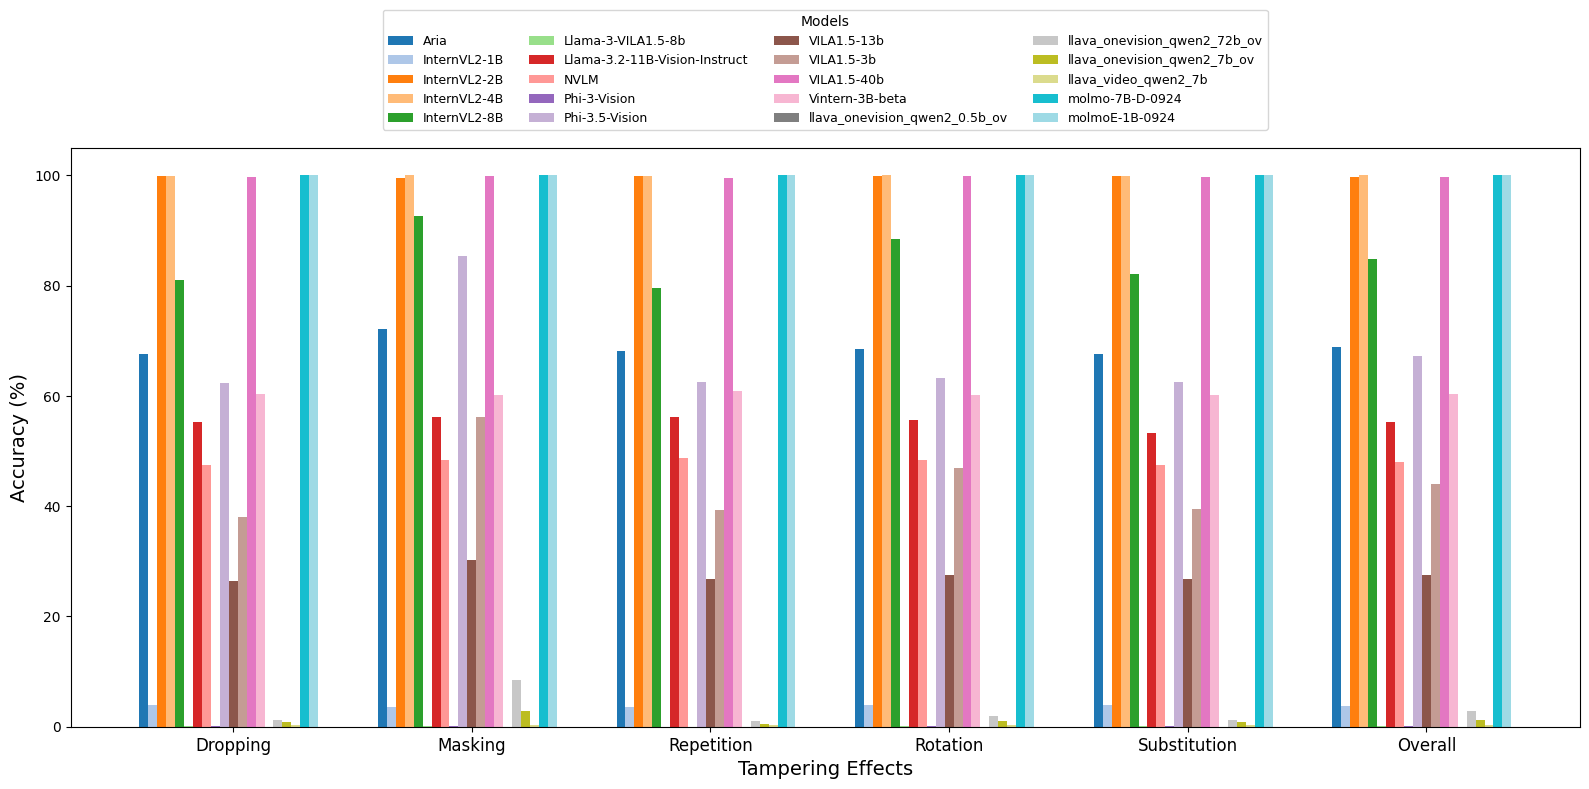

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
effects = ["Dropping", "Masking", "Repetition", "Rotation", "Substitution", "Overall"]
models = [
    "Aria", "InternVL2-1B", "InternVL2-2B", "InternVL2-4B", "InternVL2-8B",
    "Llama-3-VILA1.5-8b", "Llama-3.2-11B-Vision-Instruct", "NVLM", "Phi-3-Vision",
    "Phi-3.5-Vision", "VILA1.5-13b", "VILA1.5-3b", "VILA1.5-40b", "Vintern-3B-beta",
    "llava_onevision_qwen2_0.5b_ov", "llava_onevision_qwen2_72b_ov", "llava_onevision_qwen2_7b_ov",
    "llava_video_qwen2_7b", "molmo-7B-D-0924", "molmoE-1B-0924"
]

# Accuracy values
data = np.array([
    [67.68, 3.89, 99.82, 99.97, 81.11, 0.05, 55.24, 47.50, 0.11, 62.42, 26.39, 38.00, 99.68, 60.26, 0.00, 1.24, 0.87, 0.34, 100.00, 100.00],
    [72.08, 3.66, 99.47, 100.00, 92.68, 0.13, 56.13, 48.29, 0.08, 85.34, 30.24, 56.16, 99.95, 60.11, 0.00, 8.42, 2.84, 0.26, 100.00, 100.00],
    [68.16, 3.53, 99.84, 99.97, 79.63, 0.03, 56.24, 48.66, 0.00, 62.55, 26.82, 39.24, 99.50, 60.89, 0.00, 1.11, 0.58, 0.29, 100.00, 100.00],
    [68.50, 3.89, 99.87, 100.00, 88.50, 0.13, 55.58, 48.29, 0.08, 63.26, 27.50, 46.95, 99.92, 60.21, 0.00, 2.03, 1.05, 0.32, 100.00, 100.00],
    [67.58, 3.87, 99.82, 99.97, 82.08, 0.05, 53.29, 47.45, 0.11, 62.53, 26.76, 39.42, 99.71, 60.24, 0.00, 1.26, 0.87, 0.32, 100.00, 100.00],
    [68.80, 3.77, 99.76, 99.98, 84.80, 0.08, 55.29, 48.04, 0.07, 67.22, 27.54, 43.95, 99.75, 60.34, 0.00, 2.81, 1.24, 0.31, 100.00, 100.00],
])

# Plot settings
bar_width = 0.75
index = np.arange(len(effects))
num_models = data.shape[1]
colors = plt.cm.tab20.colors

# Create a grouped bar chart
fig, ax = plt.subplots(figsize=(16, 8))

for i in range(num_models):
    ax.bar(index + i * bar_width / num_models, data[:, i], bar_width / num_models, label=models[i], color=colors[i % len(colors)])

# Add labels and legend
ax.set_xlabel("Tampering Effects", fontsize=14)
ax.set_ylabel("Accuracy (%)", fontsize=14)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(effects, rotation=0, fontsize=12)
ax.legend(bbox_to_anchor=(0.5, 1.02), loc='lower center', fontsize=9, ncol=4, title="Models")

# Adjust layout
plt.tight_layout()

# Save the figure in high resolution
plt.savefig("model_performance_chart.png", dpi=300, bbox_inches='tight')

# Show the chart
plt.show()


# Model Performance

Radar chart saved as effects_on_models_radar_chart_filtered_light_fill.png


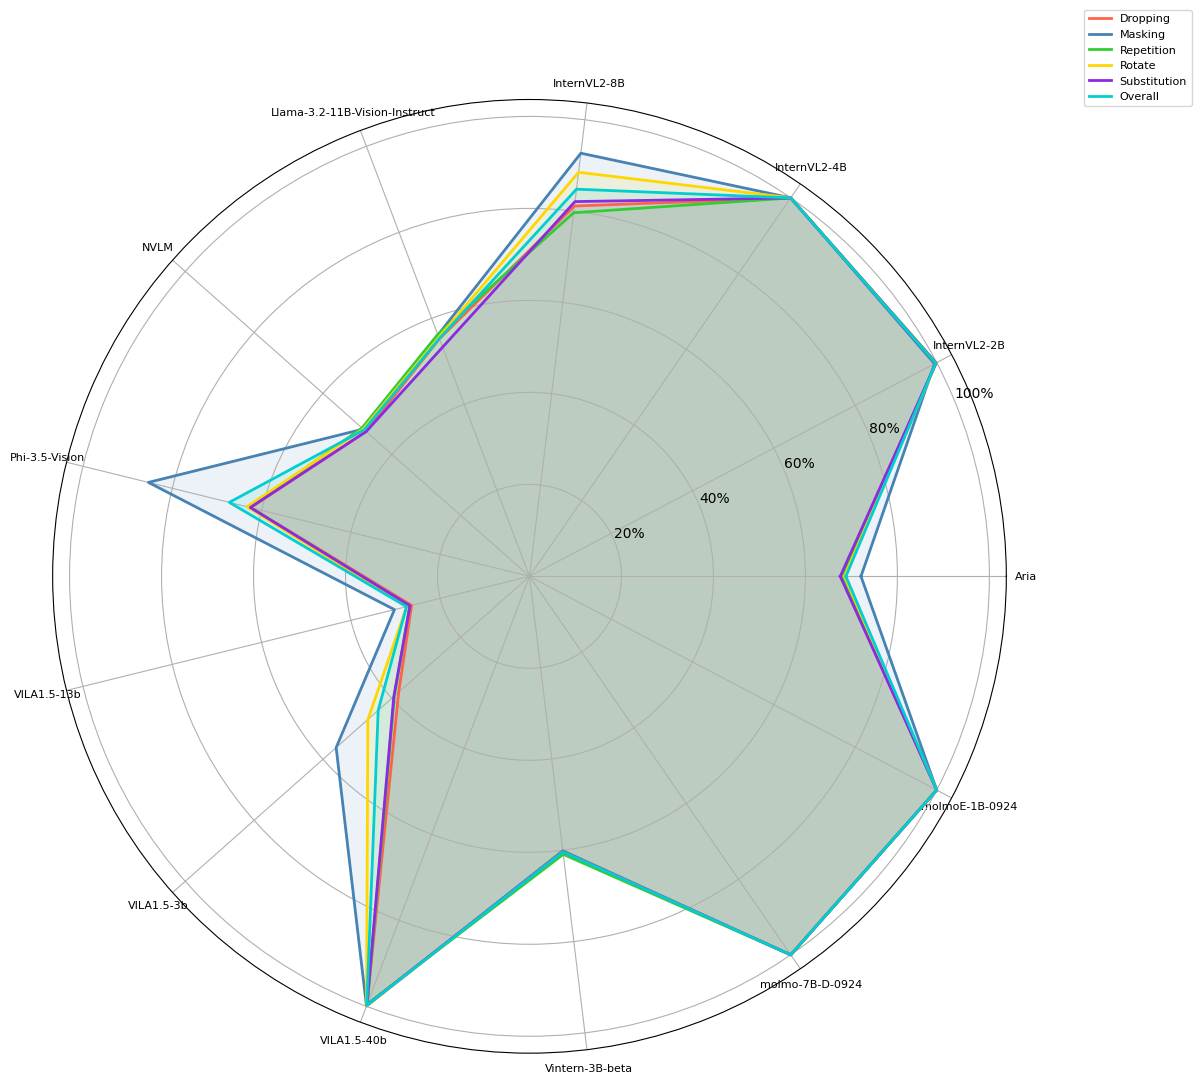

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the tampering effects and overall performance of models
effects = ['Dropping', 'Masking', 'Repetition', 'Rotate', 'Substitution', 'Overall']
models = [
    "Aria", "InternVL2-2B", "InternVL2-4B", "InternVL2-8B",
     "Llama-3.2-11B-Vision-Instruct", "NVLM",
    "Phi-3.5-Vision", "VILA1.5-13b", "VILA1.5-3b", "VILA1.5-40b", "Vintern-3B-beta",
    "molmo-7B-D-0924", "molmoE-1B-0924"
]

#Performance data for the 5 tampering effects and the overall accuracy
performance_data = {
    "Dropping": [67.68, 99.82, 99.97, 81.11, 55.24, 47.50, 62.42, 26.39, 38.00, 99.68, 60.26, 100.00, 100.00],
    "Masking": [72.08, 99.47, 100.00, 92.68, 56.13, 48.29, 85.34, 30.24, 56.16, 99.95, 60.11, 100.00, 100.00],
    "Repetition": [68.16, 99.84, 99.97, 79.63, 56.24, 48.66, 62.55, 26.82, 39.24, 99.50, 60.89, 100.00, 100.00],
    "Rotate": [68.50, 99.87, 100.00, 88.50, 55.58, 48.29, 63.26, 27.50, 46.95, 99.92, 60.21, 100.00, 100.00],
    "Substitution": [67.58, 99.82, 99.97, 82.08, 53.29, 47.45, 62.53, 26.76, 39.42, 99.71, 60.24, 100.00, 100.00],
    "Overall": [68.80, 99.76, 99.98, 84.80, 55.29, 48.04, 67.22, 27.54, 43.95, 99.75, 60.34, 100.00, 100.00]
}

# Prepare the data for plotting
num_models = len(models)
angles = np.linspace(0, 2 * np.pi, num_models, endpoint=False).tolist()
angles += angles[:1]  # Complete the loop

# Initialize the radar chart
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(polar=True))

# Colors for each effect
colors = ['#FF6347', '#4682B4', '#32CD32', '#FFD700', '#8A2BE2', '#00CED1']

# Plot each effect for each model
for i, effect in enumerate(effects):
    values = [performance_data[effect][j] for j in range(num_models)]
    values += values[:1]  # Complete the loop
    ax.plot(angles, values, label=effect, linewidth=2, color=colors[i % len(colors)])  # Darker line color
    ax.fill(angles, values, alpha=0.1, color=colors[i % len(colors)])  # Lighter fill color

# Customize the radar chart
ax.set_yticks([20, 40, 60, 80, 100])
ax.set_yticklabels(['20%', '40%', '60%', '80%', '100%'], fontsize=10)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(models, fontsize=8)


# Add a legend
ax.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1), fontsize=8)

# Save the chart as a high-resolution image
output_file = "effects_on_models_radar_chart_filtered_light_fill.png"
plt.tight_layout()
plt.savefig(output_file, dpi=300)
print(f"Radar chart saved as {output_file}")


# Heatmap of Tampering Effets on Models

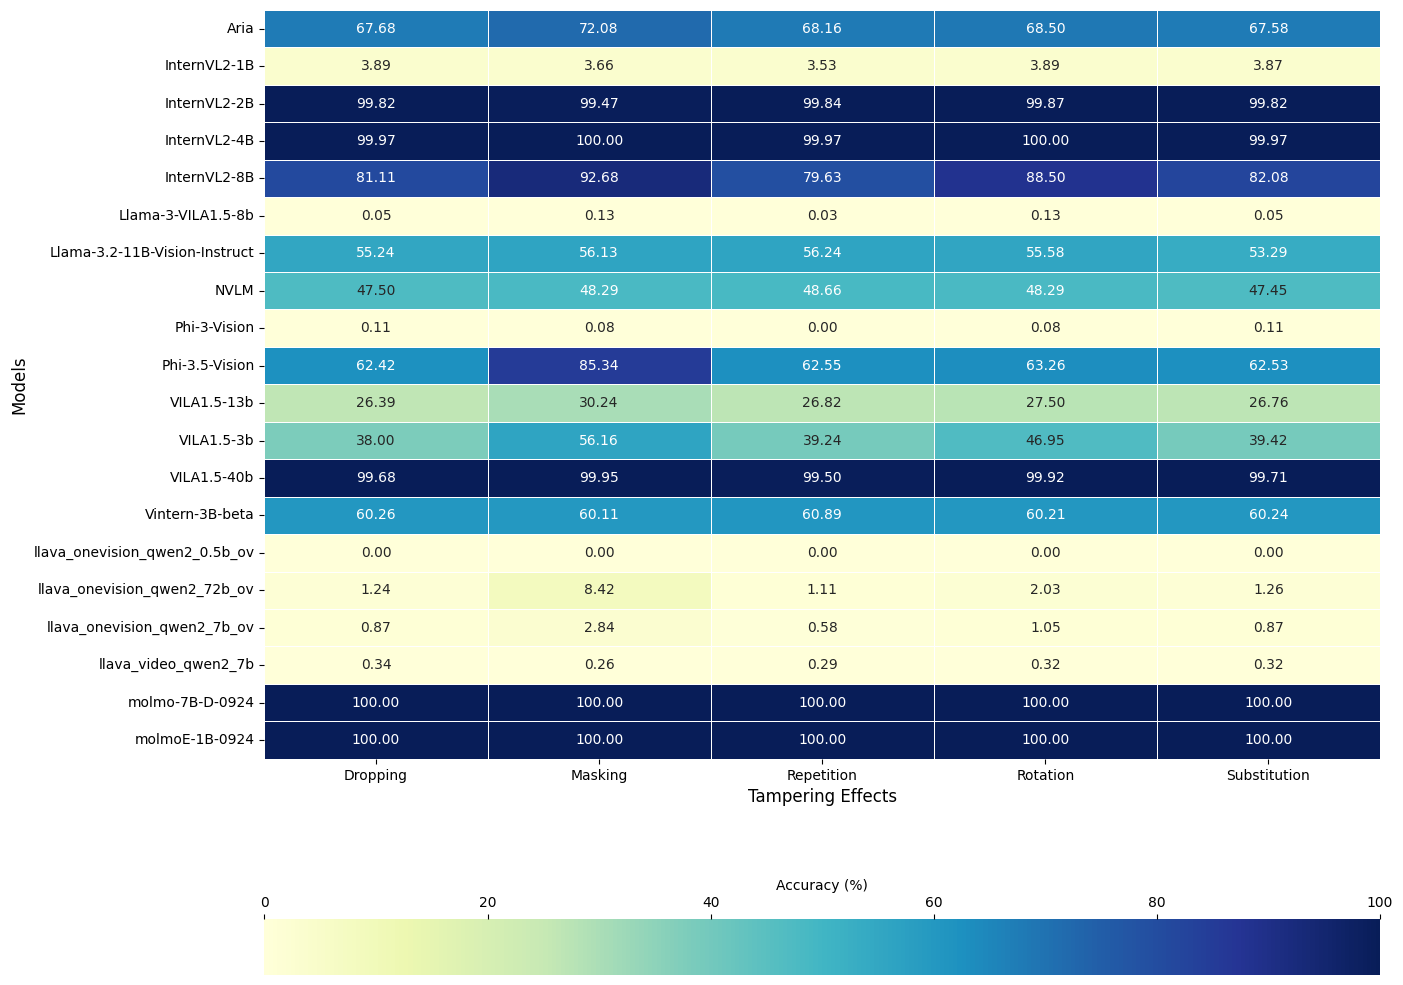

Heatmap saved as 'tampering_effects_heatmap.png' with high resolution.


In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
accuracy_data = {
    'Dropping': [67.68, 3.89, 99.82, 99.97, 81.11, 0.05, 55.24, 47.50, 0.11, 62.42, 26.39, 38.00, 99.68, 60.26, 0.00, 1.24, 0.87, 0.34, 100.00, 100.00],
    'Masking': [72.08, 3.66, 99.47, 100.00, 92.68, 0.13, 56.13, 48.29, 0.08, 85.34, 30.24, 56.16, 99.95, 60.11, 0.00, 8.42, 2.84, 0.26, 100.00, 100.00],
    'Repetition': [68.16, 3.53, 99.84, 99.97, 79.63, 0.03, 56.24, 48.66, 0.00, 62.55, 26.82, 39.24, 99.50, 60.89, 0.00, 1.11, 0.58, 0.29, 100.00, 100.00],
    'Rotation': [68.50, 3.89, 99.87, 100.00, 88.50, 0.13, 55.58, 48.29, 0.08, 63.26, 27.50, 46.95, 99.92, 60.21, 0.00, 2.03, 1.05, 0.32, 100.00, 100.00],
    'Substitution': [67.58, 3.87, 99.82, 99.97, 82.08, 0.05, 53.29, 47.45, 0.11, 62.53, 26.76, 39.42, 99.71, 60.24, 0.00, 1.26, 0.87, 0.32, 100.00, 100.00]
}
# Set up the plot
models = [
    "Aria", "InternVL2-1B", "InternVL2-2B", "InternVL2-4B", "InternVL2-8B",
    "Llama-3-VILA1.5-8b", "Llama-3.2-11B-Vision-Instruct", "NVLM", "Phi-3-Vision",
    "Phi-3.5-Vision", "VILA1.5-13b", "VILA1.5-3b", "VILA1.5-40b", "Vintern-3B-beta",
    "llava_onevision_qwen2_0.5b_ov", "llava_onevision_qwen2_72b_ov", "llava_onevision_qwen2_7b_ov",
    "llava_video_qwen2_7b", "molmo-7B-D-0924", "molmoE-1B-0924"
]
# Convert the data into a pandas DataFrame for heatmap plotting
df = pd.DataFrame(accuracy_data, index=models)

# Create the heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(
    df,
    annot=True,
    cmap='YlGnBu',
    linewidths=0.5,
    fmt='.2f',
    cbar_kws={'label': 'Accuracy (%)', 'orientation': 'horizontal'}
)

# Add labels
plt.xlabel('Tampering Effects', fontsize=12)
plt.ylabel('Models', fontsize=12)

# Move the color bar legend to the top
cbar = plt.gca().collections[0].colorbar
cbar.ax.set_position([0.25, 0.9, 0.5, 0.03])  # [x, y, width, height]
cbar.ax.xaxis.set_ticks_position('top')  # Move ticks to the top
cbar.ax.xaxis.set_label_position('top')  # Move label to the top

# Save the plot as a high-resolution image
output_file_heatmap = "tampering_effects_heatmap.png"
plt.tight_layout()
plt.savefig(output_file_heatmap, dpi=300)  # Save with high resolution (300 DPI)

# Display the plot
plt.show()

print(f"Heatmap saved as '{output_file_heatmap}' with high resolution.")
